# Collaborative Filtering – Score-Only Model

This notebook begins the modeling phase of the beer recommender system by implementing a basic collaborative filtering approach based solely on user-item interactions, specifically the review `score`.

## Objective

The primary goal of this stage is to:
- Build a collaborative filtering model using **only user IDs and beer IDs**, along with their corresponding **review scores**.
- Evaluate how well a latent factor model can learn user preferences and item characteristics using **implicit patterns in rating behavior**.
- Establish a baseline model to be enhanced in future iterations with additional beer metadata (e.g., ABV, style, availability) for hybrid recommendations.

## Methodology

- Construct a **user-beer matrix** from the cleaned review data.
- Train a basic **matrix factorization model**
- Train a **matrix factorization model** with non-linearity
- Train a **neural matrix factorization model** 
- Evaluate the model using metrics such as RMSE and top-k recommendation quality.

This foundational model serves as a benchmark against which hybrid models incorporating beer content features will be compared in later notebooks.


---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps"  if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using device: {device}")

if device.type == "cuda":
    idx = device.index or 0
    print("GPU name: ", torch.cuda.get_device_name(idx))
elif device.type == "mps":
    print("Running on Apple Silicon GPU via MPS")
else:
    print("Running on CPU")

# Loading Dataset

import pandas as pd

try:
    df = pd.read_csv('final_beers_reviews_breweries.csv')
except Exception as e:
    print(f"Error loading reviews.csv: {e}")

Using device: mps
Running on Apple Silicon GPU via MPS


---

In [2]:
df.count()

name             614525
state            614525
country          614525
style            614525
availability     614525
abv              614525
notes            614525
beer_id          614525
username         614525
date             614525
text             614525
look             614525
smell            614525
taste            614525
feel             614525
overall          614525
score            614525
name_brewery     614525
city             614525
notes_brewery    614525
types            614525
dtype: int64

### Feature Normalization

To prepare the rating-related attributes for collaborative filtering models, the following review features were scaled to a [0, 1] range using **MinMax normalization**:
- `look`
- `smell`
- `taste`
- `feel`
- `overall`
- `score`

This normalization ensures that all rating dimensions contribute equally during training, preventing attributes with larger original scales from disproportionately influencing the learning process.

#### Post-Normalization Summary:
- All normalized features have a **minimum of 0.0** and a **maximum of 1.0**.
- The distribution remains centered around **0.75**, reflecting the original skew of the review scores toward higher ratings.

This step sets a consistent numerical foundation for training latent factor models such as matrix factorization or embedding-based recommenders.


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['look', 'smell', 'taste', 'feel', 'overall', 'score']] = scaler.fit_transform(
    df[[ 'look', 'smell', 'taste', 'feel', 'overall', 'score']]
)
df.describe()

,abv,beer_id,look,smell,taste,feel,overall,score
count,614525.000000,614525.000000,614525.000000,614525.000000,614525.000000,614525.000000,614525.000000,614525.000000
mean,7.582153,13682.230450,0.754612,0.736018,0.755178,0.738499,0.751018,0.748170
std,2.353999,20065.492805,0.142259,0.159482,0.163359,0.155050,0.158492,0.140153
min,2.500000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.600000,689.000000,0.687500,0.625000,0.687500,0.625000,0.687500,0.687500
50%,7.200000,2137.000000,0.750000,0.750000,0.750000,0.750000,0.750000,0.770000
75%,9.100000,21300.000000,0.875000,0.875000,0.875000,0.875000,0.875000,0.837500
max,18.000000,148052.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### User and Item Index Mapping

To prepare the dataset for collaborative filtering with matrix-based models, each unique user and beer was assigned a numeric index:

- **User Mapping**: `username` values were mapped to a new `userIndex` column using a unique integer for each user.
- **Beer Mapping**: `beer_id` values were mapped to a `beerIndex` column similarly.

This indexing allows for efficient embedding lookup during model training.

- **Unique Users**: 15,894
- **Unique Beers**: 500  
  *(Note: This aligns with the earlier filtering to include only the top 500 most-reviewed beers.)*

### Train-Validation Split

The dataset was randomly split into:
- **Training Set**: 80% (491,620 rows)
- **Validation Set**: 20% (122,905 rows)

This split enables model training and unbiased evaluation on held-out data before proceeding to test or production deployment.


In [4]:
from sklearn.model_selection import train_test_split

# Create mapping dictionaries for users and beers
users = df['username'].unique()
userIndexDict = {user: idx for idx, user in enumerate(users)}

beers = df['beer_id'].unique()
beerIndexDict = {beer: idx for idx, beer in enumerate(beers)}

# Map the original columns to new index columns
df['userIndex'] = df['username'].map(userIndexDict)
df['beerIndex'] = df['beer_id'].map(beerIndexDict)

print("Number of unique users:", len(userIndexDict))
print("Number of unique beers:", len(beerIndexDict))

Number of unique users: 15894
Number of unique beers: 500


In [5]:
# Split the data (e.g., 80% training, 20% validation)
trainDf, valDf = train_test_split(df, test_size=0.2, random_state=42)

print("Training set shape:", trainDf.shape)
print("Validation set shape:", valDf.shape)


Training set shape: (491620, 23)
Validation set shape: (122905, 23)


---

### PyTorch Dataset and DataLoader Preparation

To enable efficient training of the collaborative filtering model in PyTorch, a custom dataset class `BeerDataset` was implemented. This class wraps the training and validation DataFrames and provides:

- **user**: Encoded user index (`userIndex`)
- **beer**: Encoded item index (`beerIndex`)
- **score**: Normalized review score as the target

Each sample is returned as a dictionary containing tensors for user, beer, and score, making it suitable for mini-batch training.

#### DataLoaders
The dataset is loaded into PyTorch `DataLoader`s:
- **Training Loader** (`trainLoader`): Uses a batch size of 256 and shuffling enabled to randomize batches during training.
- **Validation Loader** (`valLoader`): Uses the same batch size but no shuffling, preserving the order for evaluation.

These components prepare the dataset for input into an embedding-based collaborative filtering model that will learn latent user and beer representations from the interaction data.


In [6]:
import torch
from torch.utils.data import Dataset

class BeerDataset(Dataset):
    def __init__(self, df):
        self.user_ids = df['userIndex'].values
        self.beer_ids = df['beerIndex'].values
        self.scores = df['score'].values.astype('float32')
    
    def __len__(self):
        return len(self.scores)
    
    def __getitem__(self, idx):
        return {
            'user': torch.tensor(self.user_ids[idx], dtype=torch.long),
            'beer': torch.tensor(self.beer_ids[idx], dtype=torch.long),
            'score': torch.tensor(self.scores[idx], dtype=torch.float)
        }

trainDataset = BeerDataset(trainDf)
valDataset = BeerDataset(valDf)


In [7]:
from torch.utils.data import DataLoader

trainLoader = DataLoader(trainDataset, batch_size=256, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=256, shuffle=False)


### Model Architecture – Matrix Factorization Recommender

This collaborative filtering model learns latent user and beer factors to predict normalized ratings via dot‐product interactions and bias terms.

#### Key Components:

- **Embedding Layers**  
- **`user_embedding`**: Learns a $d$-dimensional vector $\mathbf{e}_{u}$ for each user.  
- **`beer_embedding`**: Learns a $d$-dimensional vector $\mathbf{e}_{i}$ for each beer.  

- **Bias Terms**  
  - **`user_bias`** ($b_u$): captures each user’s baseline rating offset.  
  - **`beer_bias`** ($b_i$): captures each beer’s baseline rating offset.  
  - **`global_bias`** ($b$): a learnable scalar representing the overall average rating.  

- **Initialization**  
  - **Embeddings**: weights sampled from a normal distribution $\mathcal{N}(0, 0.1)$ 
  - **Biases**: all bias terms initialized to 0  

- **Prediction**  
  - **Raw score**:  
    $$r_{u,i} = \mathbf{p}_u \cdot \mathbf{q}_i \;+\; b_u \;+\; b_i \;+\; b$$  
  - **Clamped output**:  
    $$\hat{r}_{u,i} = \mathrm{clamp}\bigl(r_{u,i},\,0,\,1\bigr)$$  
  First computes the dot product of user and beer embeddings with bias terms, then clamps the result to \([0,1]\).  


In [8]:
import torch.nn as nn

class MF_Recommender(nn.Module):
    def __init__(self, num_users, num_beers, embedding_dim=32):
        super(MF_Recommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.beer_embedding = nn.Embedding(num_beers, embedding_dim)
        
        self.user_bias = nn.Embedding(num_users, 1)
        self.beer_bias = nn.Embedding(num_beers, 1)
        self.global_bias = nn.Parameter(torch.tensor(0.0))

        nn.init.normal_(self.user_embedding.weight, 0, 0.1)
        nn.init.normal_(self.beer_embedding.weight, 0, 0.1)
        nn.init.constant_(self.user_bias.weight, 0.0)
        nn.init.constant_(self.beer_bias.weight, 0.0)
    
    def forward(self, user, beer):
        user_emb = self.user_embedding(user)   # Shape: (batch_size, embedding_dim)
        beer_emb = self.beer_embedding(beer)     # Shape: (batch_size, embedding_dim)
        
        rating = (user_emb * beer_emb).sum(dim=1)
        u_bias = self.user_bias(user).squeeze(1)     # (batch,)
        b_bias = self.beer_bias(beer).squeeze(1)     # (batch,)
        
        rating = rating + u_bias + b_bias + self.global_bias
        rating = rating.clamp(min=0.0, max=1.0)
        return rating

# Initialize model parameters
userCount = len(userIndexDict)
beerCount = len(beerIndexDict)
mf_model = MF_Recommender(userCount, beerCount, embedding_dim=32)
mf_model = mf_model.to(device)

for name, param in mf_model.named_parameters():
    print(name, tuple(param.shape), param.requires_grad)

global_bias () True
user_embedding.weight (15894, 32) True
beer_embedding.weight (500, 32) True
user_bias.weight (15894, 1) True
beer_bias.weight (500, 1) True


---

### Model Architecture – Nonlinear Matrix Factorization Recommender

This collaborative filtering model enhances standard MF by passing the concatenated user and beer embeddings through a two-layer MLP to capture non‐linear interactions.

#### Key Components:

- **Embedding Layers**  
  - **`user_embedding`**: Learns a $d$-dimensional vector $\mathbf{e}_{u}$ for each user.  
  - **`beer_embedding`**: Learns a $d$-dimensional vector $\mathbf{e}_{i}$ for each beer.

- **Bias Terms**  
  - **`user_bias`** ($b_u$): captures each user’s baseline rating offset.  
  - **`beer_bias`** ($b_i$): captures each beer’s baseline rating offset.

- **MLP Layers**  
  - **`fc1`**: Linear layer mapping $2d \to h$, followed by ReLU activation, where $h$ is the hidden dimension.  
  - **`fc2`**: Linear layer mapping $h \to 1$, producing the base interaction score.

- **Initialization**  
  - **Embeddings**: weights sampled from a normal distribution $\mathcal{N}(0, 0.1)$  
  - **Biases**: all bias terms initialized to 0.
  - **Model Dimensions**: `embedding_dim=32`, `hidden_dim=64`  

- **Forward Pass**  
  1. **Concatenate embeddings**:  
     $$x = [\,\mathbf{e}_{u} \,\|\, \mathbf{e}_{i}\,]$$  
  2. **Hidden activation**:  
     $$\mathbf{h} = \mathrm{ReLU}\bigl(\mathrm{fc1}(x)\bigr)$$  
  3. **Base score**:  
     $$r_{u,i} = \mathrm{fc2}(\mathbf{h}) + b_u + b_i$$  
  4. **Clamped output**:  
     $$\hat{r}_{u,i} = \mathrm{clamp}\bigl(r_{u,i},\,0,\,1\bigr)$$  


In [9]:
class NonLinear_MF_Recommender(nn.Module):
    def __init__(self, num_users, num_beers, embedding_dim=32, hidden_dim=64):
        super(NonLinear_MF_Recommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.beer_embedding = nn.Embedding(num_beers, embedding_dim)
        
        self.user_bias = nn.Embedding(num_users, 1)
        self.beer_bias = nn.Embedding(num_beers, 1)

        self.fc1 = nn.Linear(2*embedding_dim, hidden_dim, bias=True)
        self.fc2 = nn.Linear(hidden_dim, 1, bias=True)

        nn.init.normal_(self.user_embedding.weight, 0, 0.1)
        nn.init.normal_(self.beer_embedding.weight, 0, 0.1)
        nn.init.constant_(self.user_bias.weight, 0.0)
        nn.init.constant_(self.beer_bias.weight, 0.0)
    
    def forward(self, user, beer):
        user_emb = self.user_embedding(user)   # Shape: (batch_size, embedding_dim)
        beer_emb = self.beer_embedding(beer)     # Shape: (batch_size, embedding_dim)

        x = torch.cat([user_emb, beer_emb], dim=1)
        h = torch.relu(self.fc1(x))   
        rating = self.fc2(h).squeeze(1)
        
        u_bias = self.user_bias(user).squeeze(1)     # (batch,)
        b_bias = self.beer_bias(beer).squeeze(1)     # (batch,)
        
        rating = rating + u_bias + b_bias
        rating = rating.clamp(min=0.0, max=1.0)
        return rating

nonlinear_mf_model = NonLinear_MF_Recommender(userCount, beerCount)
nonlinear_mf_model = nonlinear_mf_model.to(device)

for name, param in nonlinear_mf_model.named_parameters():
    print(name, tuple(param.shape), param.requires_grad)

user_embedding.weight (15894, 32) True
beer_embedding.weight (500, 32) True
user_bias.weight (15894, 1) True
beer_bias.weight (500, 1) True
fc1.weight (64, 64) True
fc1.bias (64,) True
fc2.weight (1, 64) True
fc2.bias (1,) True


---

### Model Architecture – Neural Matrix Factorization (NeuMF) Recommender

This hybrid model combines a linear Generalized Matrix Factorization(GMF) branch with a non-linear MLP branch to capture both simple and complex user–item interactions.

#### Key Components:

- **GMF Branch**  
  - `gmf_user_embedding`: 64-dimensional user embeddings  
  - `gmf_beer_embedding`: 64-dimensional beer embeddings  

- **MLP Branch**  
  - `mlp_user_embedding`: 64-dimensional user embeddings  
  - `mlp_beer_embedding`: 64-dimensional beer embeddings  
  - **MLP Layers:**  
    - **Input:** concatenated user & beer embeddings (128 dims)  
    - **Hidden dims:** 128 → 64 → 32 → 16  
    - **Activation:** ReLU  
    - **Dropout:** 20%  

- **Bias Terms**  
  - `user_bias` ($b_u$) and `beer_bias` ($b_i$): per-user and per-beer offsets  

- **Fusion & Prediction**  
  - **Concatenate:** GMF output (64 dims) + MLP output (16 dims) → 80 dims  
  - `predict_layer`: Linear(80 → 1)  
  - **Add biases** and **clamp** to [0,1]  

- **Initialization**  
  - **Embeddings:** weights sampled from a normal distribution $\mathcal{N}(0, 0.1)$  
  - **Biases:** initialized to 0  

#### Forward Pass Steps:

1. **GMF computation:**  
   $$\mathbf{g}_{u,i} = \mathbf{e}_u^{\text{gmf}} \odot \mathbf{e}_i^{\text{gmf}}$$  
2. **MLP computation:**  
   - Concatenate $\mathbf{e}_u^{\text{mlp}}$ and $\mathbf{e}_i^{\text{mlp}}$ (128 dims)  
   - Pass through MLP:  
     $$128 \xrightarrow{\text{ReLU+Dropout}}64 \xrightarrow{\text{ReLU+Dropout}}32 \xrightarrow{\text{ReLU+Dropout}}16$$  
3. **Fusion:**  
   Concatenate GMF (64) & MLP (16) → 80 dims → `predict_layer` → raw score  
4. **Prediction:**  
   $$r_{u,i} = \text{raw\_score} + b_u + b_i$$  
   $$\hat{r}_{u,i} = \mathrm{clamp}(r_{u,i},\,0,\,1)$$  


In [19]:
class NeuMF_Recommender(nn.Module):
    def __init__(self,num_users, num_beers, gmf_dim = 32, mlp_dim = 32, mlp_layers = [64, 32]):
        super(NeuMF_Recommender, self).__init__()
        self.gmf_user_embedding = nn.Embedding(num_users, gmf_dim)
        self.gmf_beer_embedding = nn.Embedding(num_beers, gmf_dim)

        self.mlp_user_embedding = nn.Embedding(num_users, mlp_dim)
        self.mlp_beer_embedding = nn.Embedding(num_beers, mlp_dim)

        self.user_bias = nn.Embedding(num_users, 1)
        self.beer_bias = nn.Embedding(num_beers, 1)

        mlp_modules = []
        input_size = 2 * mlp_dim
        for h in mlp_layers:
            mlp_modules += [nn.Linear(input_size, h), nn.ReLU(), nn.Dropout(0.2)]
            input_size = h
        self.mlp = nn.Sequential(*mlp_modules)

        final_dim = gmf_dim + mlp_layers[-1]
        self.predict_layer = nn.Linear(final_dim, 1, bias=True)

        # — initialize weights & biases —
        nn.init.normal_(self.gmf_user_embedding.weight,  0, 0.1)
        nn.init.normal_(self.gmf_beer_embedding.weight,  0, 0.1)
        nn.init.normal_(self.mlp_user_embedding.weight,  0, 0.1)
        nn.init.normal_(self.mlp_beer_embedding.weight,  0, 0.1)
        nn.init.constant_(self.user_bias.weight, 0.0)
        nn.init.constant_(self.beer_bias.weight, 0.0)

    def forward(self, user, beer):
        gmf_user = self.gmf_user_embedding(user)
        gmf_beer = self.gmf_beer_embedding(beer)
        gmf_out = gmf_user * gmf_beer  # (batch, gmf_dim)

        mlp_user = self.mlp_user_embedding(user)
        mlp_beer = self.mlp_beer_embedding(beer)
        mlp_in = torch.cat([mlp_user, mlp_beer], dim=1)
        mlp_out = self.mlp(mlp_in)  # (batch, mlp_layers[-1])

        # Fuse branches
        x = torch.cat([gmf_out, mlp_out], dim=1)  # (batch, final_dim)
        out = self.predict_layer(x).squeeze(1) 

        user_bias = self.user_bias(user).squeeze(1)
        beer_bias = self.beer_bias(beer).squeeze(1)
        
        rating = out + user_bias + beer_bias 
        rating = rating.clamp(min=0.0, max=1.0)
        
        return rating
        
neu_mf_model = NeuMF_Recommender(userCount, beerCount, gmf_dim = 32, mlp_dim = 32, mlp_layers=[ 64, 32])
neu_mf_model = neu_mf_model.to(device)

for name, param in neu_mf_model.named_parameters():
    print(name, tuple(param.shape), param.requires_grad)

gmf_user_embedding.weight (15894, 32) True
gmf_beer_embedding.weight (500, 32) True
mlp_user_embedding.weight (15894, 32) True
mlp_beer_embedding.weight (500, 32) True
user_bias.weight (15894, 1) True
beer_bias.weight (500, 1) True
mlp.0.weight (64, 64) True
mlp.0.bias (64,) True
mlp.3.weight (32, 64) True
mlp.3.bias (32,) True
predict_layer.weight (1, 64) True
predict_layer.bias (1,) True


---

### Training Utility – `trainModel`

Encapsulates the training loop for collaborative filtering models using MSE loss and the Adam optimizer.

#### Key Parameters

- **`model`**: the PyTorch module to train  
- **`lr`** (default = 1e-3): learning rate for Adam  
- **`weight_decay`** (default = 1e-5): L2 regularization strength  
- **`num_epochs`** (default = 30): total training epochs  

#### Workflow

1. **Setup**  
   - Instantiate `criterion = nn.MSELoss()`  
   - Instantiate `optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)`  

2. **Epoch Loop**  
   - For each epoch:  
     - Switch model to training mode (`model.train()`)  
     - Iterate batches from `trainLoader`:  
       - Move `user`, `beer`, and `score` to `device`  
       - Zero gradients, compute `predictions = model(user, beer)`, compute `loss = criterion(predictions, score)`, backpropagate and update parameters  
       - Accumulate `loss.item()`  
     - Compute and print average epoch loss  

3. **Visualization**  
   - Plot the epoch-wise loss curve with `matplotlib`  

This function prints per-epoch training loss and displays a loss-vs-epoch plot for convergence monitoring.  


In [13]:
import torch.optim as optim

def trainModel(model, lr = 1e-3, weight_decay = 1e-5, num_epochs = 30):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    numEpochs = num_epochs  # Adjust as needed
    losses = [] #added to store avg loss per epoch
    
    for epoch in range(numEpochs):
        model.train()
        totalLoss = 0.0
        for batch in trainLoader:
            user = batch['user'].to(device)
            beer = batch['beer'].to(device)
            rating = batch['score'].to(device)
    
            optimizer.zero_grad()
            predictions = model(user, beer)
            loss = criterion(predictions, rating)
            loss.backward()
            optimizer.step()
            
            totalLoss += loss.item()
        
        avgLoss = totalLoss / len(trainLoader)
        losses.append(avgLoss)
        print(f"Epoch {epoch+1}/{numEpochs}, Loss: {avgLoss:.4f}")
    
    import matplotlib.pyplot as plt
    
    plt.plot(losses)
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

---

### Evaluation Utility – `evalModel`

Encapsulates the validation loop to compute MSE and RMSE on the hold-out set.

#### Workflow
1. Move the model to `device` and switch to evaluation mode (`model.eval()`).  
2. Initialize `criterion = nn.MSELoss()` and `totalValLoss = 0.0`.  
3. Disable gradient tracking and iterate over `valLoader`:  
   - Transfer `user`, `beer`, and `score` to `device`.  
   - Compute `predictions = model(user, beer)`.  
   - Calculate `loss = criterion(predictions, score)` and accumulate `loss * batch_size`.  
4. After the loop, compute:  
   - `avgValLoss = totalValLoss / len(valDataset)`  
   - `rmse = avgValLoss ** 0.5`  
5. Print the results:  
   - `Validation MSE: {avgValLoss:.4f}`  
   - `Validation RMSE: {rmse:.4f}`  
6. Return `avgValLoss` and `rmse` for downstream analysis.  


In [12]:
def evalModel(model):
    model.to(device)
    model.eval() 
    totalValLoss = 0.0
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for batch in valLoader:
            user = batch['user'].to(device)
            beer = batch['beer'].to(device)
            rating = batch['score'].to(device)
    
            predictions = model(user, beer)
            loss = criterion(predictions, rating)  # MSE loss
            # Multiply by batch size to sum up total loss over the dataset
            totalValLoss += loss.item() * rating.size(0)
    
    # Compute average MSE loss over the entire validation set
    avgValLoss = totalValLoss / len(valDataset)
    # RMSE is the square root of the MSE
    rmse = avgValLoss ** 0.5
    
    print(f"Validation MSE: {avgValLoss:.4f}")
    print(f"Validation RMSE: {rmse:.4f}")
    return avgValLoss, rmse


---

### Model Training and Evaluation: Matrix Factorization

The MF_Recommender model is a  implementation of matrix factorization:

#### Observations:
- Initial loss started at **0.3575**, dropping sharply to **0.0283** by epoch 3.  
- Loss continued to decrease gradually, reaching **0.0078** at the final epoch.  
- The training loss curve shows a steady downward trend, indicating effective learning without early plateau.  

After training, the model was evaluated on the held-out validation set using the same MSE loss under `torch.no_grad()` to disable gradient computation.

#### Metrics:
- **Mean Squared Error (MSE)**: Average of squared differences between predicted and actual ratings.  
- **Root Mean Squared Error (RMSE)**: Square root of MSE, for interpretability on the [0,1] scale.  

#### Results:
- **Validation MSE**: 0.0099  
- **Validation RMSE**: 0.0994  

These metrics demonstrate that the matrix factorization model generalizes well, achieving an average prediction error of 0.0994 on the normalized rating scale.  


Model: mf_model
Epoch 1/30, Loss: 0.3575
Epoch 2/30, Loss: 0.1082
Epoch 3/30, Loss: 0.0283
Epoch 4/30, Loss: 0.0142
Epoch 5/30, Loss: 0.0118
Epoch 6/30, Loss: 0.0107
Epoch 7/30, Loss: 0.0101
Epoch 8/30, Loss: 0.0098
Epoch 9/30, Loss: 0.0096
Epoch 10/30, Loss: 0.0094
Epoch 11/30, Loss: 0.0093
Epoch 12/30, Loss: 0.0092
Epoch 13/30, Loss: 0.0091
Epoch 14/30, Loss: 0.0090
Epoch 15/30, Loss: 0.0089
Epoch 16/30, Loss: 0.0088
Epoch 17/30, Loss: 0.0087
Epoch 18/30, Loss: 0.0086
Epoch 19/30, Loss: 0.0086
Epoch 20/30, Loss: 0.0085
Epoch 21/30, Loss: 0.0084
Epoch 22/30, Loss: 0.0083
Epoch 23/30, Loss: 0.0082
Epoch 24/30, Loss: 0.0082
Epoch 25/30, Loss: 0.0081
Epoch 26/30, Loss: 0.0080
Epoch 27/30, Loss: 0.0080
Epoch 28/30, Loss: 0.0079
Epoch 29/30, Loss: 0.0079
Epoch 30/30, Loss: 0.0078


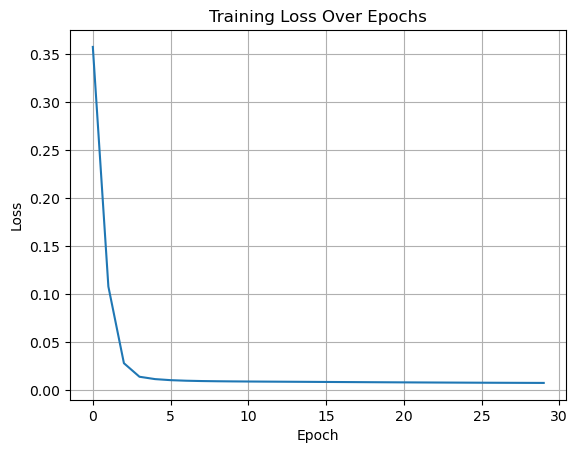

Validation MSE: 0.0099
Validation RMSE: 0.0994


(0.009884826537200605, 0.09942246495234669)

In [14]:
print("Model: mf_model")
trainModel(mf_model, lr=1e-4, weight_decay=1e-5, num_epochs=30)
evalModel(mf_model)

---

### Model Training and Evaluation: Nonlinear Matrix Factorization

The NonLinear_MF_Recommender model enhances traditional matrix factorization by incorporating :

A multi-layer perceptron (MLP) structure to model nonlinear interactions between user and beer embeddings.

  
#### Observations:
- Loss decreased from **0.0893** in epoch 1 to **0.0082** by epoch 30.  
- Convergence was smooth, with no signs of overfitting.  

After training, the model was evaluated on the held-out validation set in inference mode (`torch.no_grad()`).

#### Metrics:
- **Validation MSE**: 0.0105 
- **Validation RMSE**: 0.1026

Compared to the linear MF baseline (MSE = 0.0100), the nonlinear model shows comparable performance, suggesting limited additional gain from the MLP branch on this dataset.  


Model: nonlinear_mf_model
Epoch 1/30, Loss: 0.0893
Epoch 2/30, Loss: 0.0110
Epoch 3/30, Loss: 0.0104
Epoch 4/30, Loss: 0.0101
Epoch 5/30, Loss: 0.0099
Epoch 6/30, Loss: 0.0098
Epoch 7/30, Loss: 0.0098
Epoch 8/30, Loss: 0.0097
Epoch 9/30, Loss: 0.0097
Epoch 10/30, Loss: 0.0097
Epoch 11/30, Loss: 0.0096
Epoch 12/30, Loss: 0.0096
Epoch 13/30, Loss: 0.0095
Epoch 14/30, Loss: 0.0094
Epoch 15/30, Loss: 0.0093
Epoch 16/30, Loss: 0.0092
Epoch 17/30, Loss: 0.0091
Epoch 18/30, Loss: 0.0090
Epoch 19/30, Loss: 0.0090
Epoch 20/30, Loss: 0.0089
Epoch 21/30, Loss: 0.0088
Epoch 22/30, Loss: 0.0087
Epoch 23/30, Loss: 0.0087
Epoch 24/30, Loss: 0.0086
Epoch 25/30, Loss: 0.0085
Epoch 26/30, Loss: 0.0085
Epoch 27/30, Loss: 0.0084
Epoch 28/30, Loss: 0.0083
Epoch 29/30, Loss: 0.0083
Epoch 30/30, Loss: 0.0082


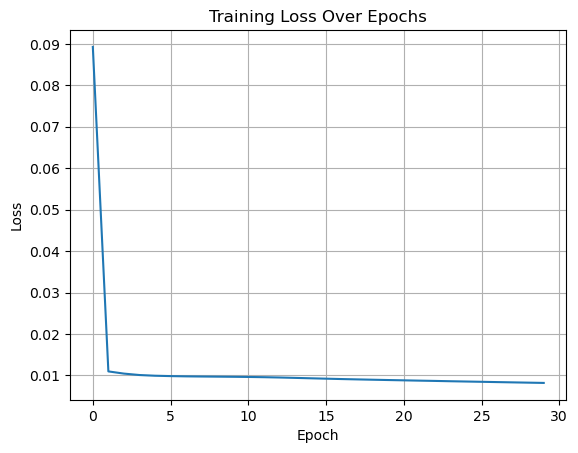

Validation MSE: 0.0105
Validation RMSE: 0.1026


(0.010516583123636675, 0.10255039309352586)

In [15]:
print("Model: nonlinear_mf_model")
trainModel(nonlinear_mf_model,lr=1e-4, weight_decay=1e-5, num_epochs=30)
evalModel(nonlinear_mf_model)

---

### Model Training and Evaluation: Neural Matrix Factorization

The **NeuMF_Recommender** integrates:
- **Generalized Matrix Factorization (GMF)** and **MLP-based collaborative filtering**, 
- Combining both **latent interactions** and **learned non-linear patterns** for final rating prediction.

#### Observations:
- Loss dropped from **0.0805** in epoch 1 to **0.0170** by epoch 3, then plateaued through epoch 20.  
- Fast convergence and stable training curve indicate effective learning without overfitting.  

After training, the model was evaluated on the held-out validation set in inference mode (`torch.no_grad()`).

#### Metrics:
- **Validation MSE**: 0.0101 
- **Validation RMSE**: 0.1006

Compared to both the linear and nonlinear MF variants, NeuMF shows similar error, implying that the added complexity of fusing GMF and MLP branches did not translate into significant performance gains on this dataset.  


Model: neu_mf_model
Epoch 1/30, Loss: 0.0805
Epoch 2/30, Loss: 0.0185
Epoch 3/30, Loss: 0.0165
Epoch 4/30, Loss: 0.0146
Epoch 5/30, Loss: 0.0129
Epoch 6/30, Loss: 0.0117
Epoch 7/30, Loss: 0.0109
Epoch 8/30, Loss: 0.0104
Epoch 9/30, Loss: 0.0101
Epoch 10/30, Loss: 0.0098
Epoch 11/30, Loss: 0.0096
Epoch 12/30, Loss: 0.0095
Epoch 13/30, Loss: 0.0094
Epoch 14/30, Loss: 0.0094
Epoch 15/30, Loss: 0.0093
Epoch 16/30, Loss: 0.0093
Epoch 17/30, Loss: 0.0093
Epoch 18/30, Loss: 0.0092
Epoch 19/30, Loss: 0.0092
Epoch 20/30, Loss: 0.0092
Epoch 21/30, Loss: 0.0091
Epoch 22/30, Loss: 0.0091
Epoch 23/30, Loss: 0.0091
Epoch 24/30, Loss: 0.0090
Epoch 25/30, Loss: 0.0090
Epoch 26/30, Loss: 0.0090
Epoch 27/30, Loss: 0.0090
Epoch 28/30, Loss: 0.0089
Epoch 29/30, Loss: 0.0089
Epoch 30/30, Loss: 0.0088


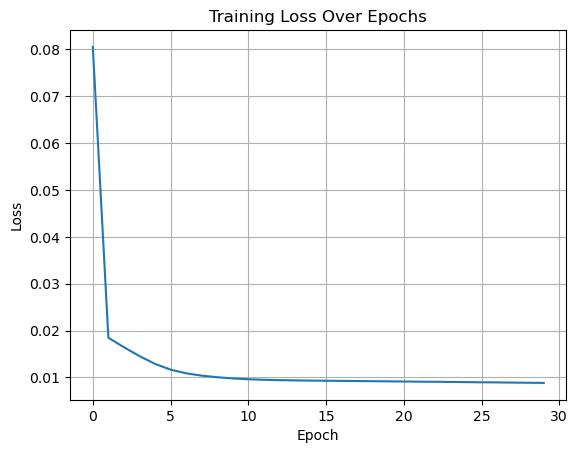

Validation MSE: 0.0101
Validation RMSE: 0.1006


(0.010116382100930472, 0.10058022718671136)

In [20]:
print("Model: neu_mf_model")
trainModel(neu_mf_model, lr=1e-4, weight_decay=1e-5, num_epochs=30)
evalModel(neu_mf_model)

---

## Recommendation Utilities for Real vs Predicted Preferences

This section establishes utility functions to interpret and evaluate the outputs of the trained collaborative filtering model, particularly for generating beer recommendations and validating them against real user preferences.

---


In [21]:
# Run this cell for necessary tility methods for Collaborative Filtering Model
indexBeerDict = {index: beer for beer, index in beerIndexDict.items()}
indexUserMap = {index: user for user, index in userIndexDict.items()}

def topKRecommendedBeersForUser(model, userIndex, topK=10):

    model.to(device)
    model.eval()
    allBeerIndices = torch.arange(len(beerIndexDict)).to(device)
    userTensor = torch.tensor([userIndex] * len(beerIndexDict), dtype=torch.long).to(device)
    with torch.no_grad():
        predictedRatings = model(userTensor, allBeerIndices)
    topRatings, topBeerIndices = torch.topk(predictedRatings, topK)
    recommendedBeers = [indexBeerDict[index.item()] for index in topBeerIndices]
    return recommendedBeers,topRatings

beerDetails = df.groupby('beer_id').agg({
    'name': 'first',
    'state': 'first',
    'country': 'first',
    'style': 'first',
    'availability': 'first',
    'abv': 'mean',
    'notes': 'first',
    'look': 'mean',
    'smell': 'mean',
    'taste': 'mean',
    'feel': 'mean',
    'overall': 'mean',
    'score': 'mean',
    'name_brewery': 'first',
    'city': 'first',
    'notes_brewery': 'first',
    'types': 'first'
}).reset_index()

def getBeerDetailsFromIds(beerIdList):
    df_idx = beerDetails.set_index('beer_id')
    df_out = df_idx.loc[beerIdList]
    return df_out.reset_index()

def getBeerDetailsFromIdsWithPredictedScore(beerIdList, predictedScores):
    df_beerDetails = getBeerDetailsFromIds(beerIdList)[['name', 'style', 'abv', 'score']]
    scores = predictedScores.detach().cpu().tolist()
    df_beerDetails['predicted_user_score'] = scores
    return df_beerDetails
    
def getActualTopKReviewedBeersForUser(username, topK=10):
    userReviews = df[df['username'] == username]
    return userReviews.sort_values(by='score', ascending=False).head(topK)

def getUsername(userIndex):
    username = indexUserMap.get(userIndex, "Unknown User")
    print(f"Username for user index {userIndex}: {username}")
    return username

In [23]:
# For a given user index get the actual top K reviewed beers:
userIndex = 111
username = getUsername(userIndex)
topK = 10
print(getActualTopKReviewedBeersForUser(username, topK)[['name', 'style', 'abv', 'score']])

recommended_beer_ids, predictedRatings = topKRecommendedBeersForUser(
    neu_mf_model,
    userIndex,
    topK=topK
)

df_beerDetails = getBeerDetailsFromIdsWithPredictedScore(recommended_beer_ids, predictedRatings)
print(df_beerDetails.to_string(index=False))

Username for user index 111: jbaker67
                                     name                    style   abv  \
185003                           Parabola   Russian Imperial Stout  12.7   
482765  Bourbon County Brand Coffee Stout  American Imperial Stout  12.9   
586086                    Pliny The Elder    American Imperial IPA   8.0   
588621                         Temptation        American Wild Ale   7.5   
511964                         Pseudo Sue  American Pale Ale (APA)   6.2   
329277     KBS (Kentucky Breakfast Stout)  American Imperial Stout  12.3   
539942        Cantillon Kriek 100% Lambic     Belgian Fruit Lambic   5.0   
600619                       Heady Topper          New England IPA   8.0   
612881                              Bomb!  American Imperial Stout  13.0   
186130                             §ucaba       British Barleywine  12.5   

         score  
185003  0.9150  
482765  0.9150  
586086  0.9125  
588621  0.9125  
511964  0.9000  
329277  0.8900  
539942

### 📌 Insights

- **Preference Profile**: The selected user (`jbaker67`) consistently gives high ratings to strong, dark, and often Stout and IPAs. This highlights a preference for high-ABV, full-bodied, and complex beers.

- **Consistency in Taste**: All top-rated beers fall into either the IPA, Quadrupel, or Imperial Stout categories, suggesting that taste preferences remain stable across styles that share richness, depth, and higher alcohol content.

- **Metadata Utility**: The ability to aggregate and query detailed beer metadata enables clear interpretation of what the model is recommending and why. This provides transparency and supports explainability in the recommendation process.

- **Validation Readiness**: These utilities allow for real-time comparison between model-generated recommendations and a user's historical top ratings. Such comparison is critical for iterative improvement of the recommender system.

- **Future Direction**: Insights from user behavior and rating trends can be used to guide enhancements in hybrid models—for example, by integrating beer features like style and ABV directly into the model architecture for personalized embeddings.

- **Model Explainability**: This framework bridges machine-generated predictions and human-readable outputs, an essential component for user trust and system transparency in real-world recommender applications.


---

### Conclusion: Collaborative Filtering Model

The initial collaborative filtering model, which uses only user and beer IDs along with learned embeddings and biases, demonstrated strong baseline performance in predicting beer ratings. The training process showed a consistent reduction in loss over 30 epochs, and the model achieved a low RMSE of **0.1006** on the validation set—indicative of high predictive accuracy.

Key strengths of the model include:
- **Effective personalization** through embedding layers for both users and beers.
- **Bias incorporation** at user, item, and global levels to capture rating tendencies.
- **Scalable architecture** suitable for large datasets.

However, the model has several limitations:
- It **does not leverage content-based features** such as beer style, ABV, or textual reviews, which could enhance recommendations especially for new or sparsely rated items.
- **Cold-start users or items** (those with few or no ratings) may receive poor recommendations due to lack of interaction history.
- The model lacks interpretability and explainability, making it harder to justify predictions to end users.

These vanilla model provides a solid foundation for collaborative filtering. In the next phase, we aim to incorporate **beer content features** into the model architecture to create a hybrid recommender system that can deliver even more accurate and robust recommendations across a wider range of users and items.
